In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import basemap
import scipy.stats

# Display up to n columns of a dataframe, alternate: "pd.set_option('display.max_columns', 150)"
pd.options.display.max_columns = 300

In [2]:
# Import the excel file and call it xls_file
xls_file = pd.ExcelFile('globalterrorismdb_0919dist.xlsx')
# View the excel file's sheet names
xls_file.sheet_names

['Data']

In [3]:
# Load the xls file's Sheet1 as a dataframe
df = xls_file.parse('Data')

In [ ]:
df.columns

In [4]:
print(df.shape)
df.head(3)

(191464, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,Central America & Caribbean,National,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [5]:
#reference for later
orig_df_copy = df.copy()
orig_idx = df.index
orig_idymd = df[['eventid', 'iyear', 'imonth', 'iday']]

In [6]:
df.imonth.value_counts().sort_index()

0        20
1     15839
2     14626
3     16013
4     15994
5     17827
6     16198
7     17165
8     16565
9     14939
10    16455
11    15643
12    14180
Name: imonth, dtype: int64

As you can see, 20 of the events are represented for the "imonth" column with a zero for the month. This is because the exact month it took place are unknown. When this is the case, according to the GTD codebook, 

"_For attacks that took place between 1970 and 2011, if the exact month of the event is
unknown, this is recorded as “0”. For attacks that took place after 2011, if the exact
month of the event is unknown, this is recorded as the midpoint of the range of possible
dates reported in source materials and the full range is recorded in the Approximate
Date (approxdate) field below._" - [GTD codebook](https://www.start.umd.edu/gtd/downloads/Codebook.pdf)

To build a proper datetime, these zeros will need to be taken care of because datetime needs months to be formatted between 1-12.

Lets take a look now at the "approxdate" column for all incididents with a zero for "imonth".

In [7]:
df.loc[df.imonth == 0, ['approxdate']].head()

,approxdate
1,NaN
1123,NaN
1690,NaN
2164,NaN
2165,NaN


It appears that for these incidents where month is unknown, described by a "0" in the "imonth" column, the "approxdate" column is null for all 20 observations. Even though there isnt much useful information at all as far as this goes, lets take a look at some of the things we DO know about them, such as which year they occured in, where they were carried out, type of attack, victom of attack (targtype1_txt) nationality of victom or target (natlty1_txt), as well as the group that carried out the attack.

In [8]:
attacks_unknown_month = df.loc[df.imonth == 0][['iyear', 'country_txt', 'city', 'success', 'attacktype1_txt',
                                                'weaptype1_txt', 'targtype1_txt', 'natlty1_txt', 'gname']]
attacks_unknown_month.head()

,iyear,country_txt,city,success,attacktype1_txt,weaptype1_txt,targtype1_txt,natlty1_txt,gname
1,1970,Mexico,Mexico city,1,Hostage Taking (Kidnapping),Unknown,Government (Diplomatic),Belgium,23rd of September Communist League
1123,1972,Philippines,Roxas,1,Bombing/Explosion,Explosives,Airports & Aircraft,Philippines,Unknown
1690,1973,Colombia,unknown,1,Hostage Taking (Kidnapping),Unknown,Business,Colombia,National Liberation Army of Colombia (ELN)
2164,1974,France,Paris,0,Bombing/Explosion,Explosives,Business,France,Unknown
2165,1974,Italy,Rome,1,Bombing/Explosion,Explosives,Airports & Aircraft,United States,Unknown


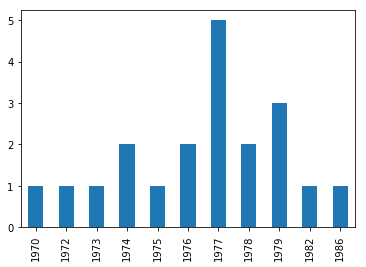

In [9]:
attacks_unknown_month.iyear.value_counts().sort_index().plot.bar()

Above we can see that attacks where the month was unknown spanned between 1970-1986, a relatively small portion of the total years the data covers (1970-2019). We can see when we bin by year that there were 2 or less per year in over half (12/20) of the observed instances where they occurred. 1977 had to most missing values with a total of 5 (out of 1319 total attacks that occured in 1977), accounting for about 0.004% of the total attacks in 1977. lets compute the percentage for each year with missing month values for all of the years.

In [10]:
attacks_unknown_month.unknown = attacks_unknown_month.iyear.rename('unknown', inplace=True)
unknown_month_each_yr = attacks_unknown_month.unknown.value_counts().sort_index()

# total number of attacks for each yr for years where there were missing month values
known_months_each_yr = df.iyear.value_counts().sort_index()[:17]

C:\Users\Emtma_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [11]:
# join series for easy computation
x = pd.concat([unknown_month_each_yr, known_months_each_yr], join='inner', axis=1)
percent_unknown_month_by_yr = round(x.unknown / x.iyear, 4)
percent_unknown_month_by_yr.sort_values(ascending=False)

1977    0.0038
1974    0.0034
1976    0.0022
1973    0.0021
1972    0.0018
1970    0.0015
1975    0.0014
1978    0.0013
1979    0.0011
1982    0.0004
1986    0.0003
dtype: float64

Very minimal number of attacks with missing month values as we can see from these percentages. the year 1977 had the most missing, but still a very small percent of all of the attacks for that year as a whole at less than 0.004%

Lets take a look at the rest of the variables of interest for this subset of our data (attacks with where the month is unknown).

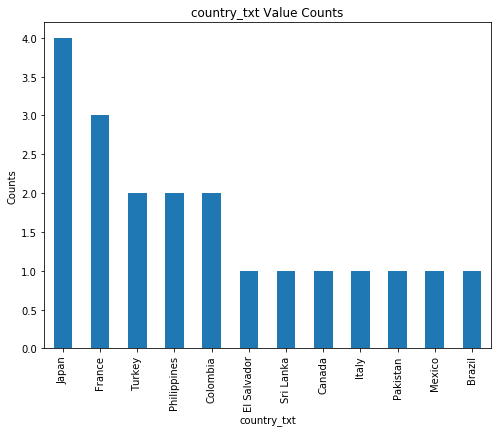

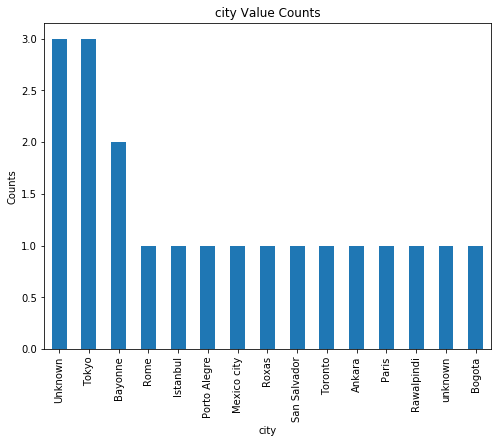

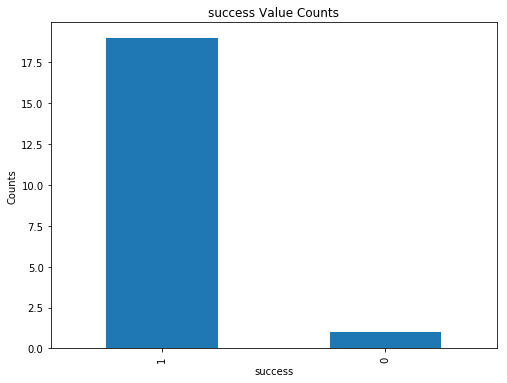

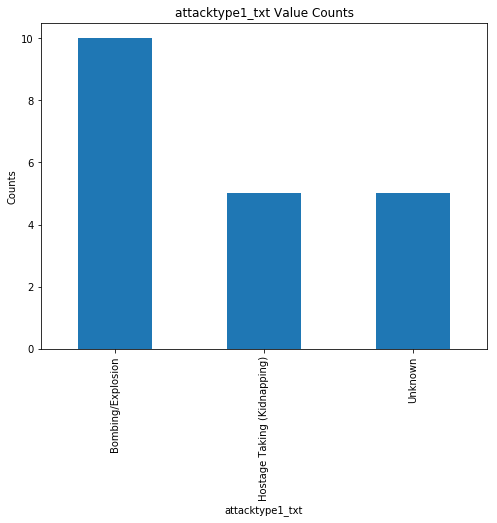

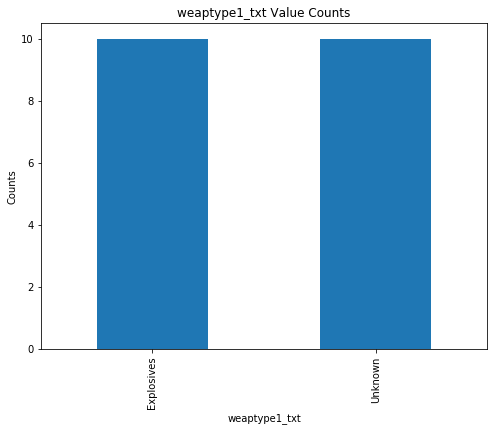

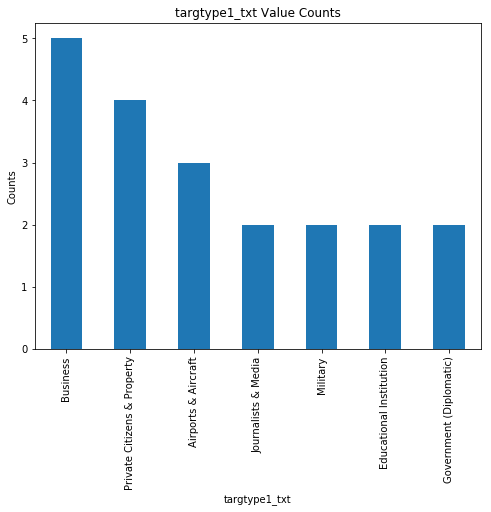

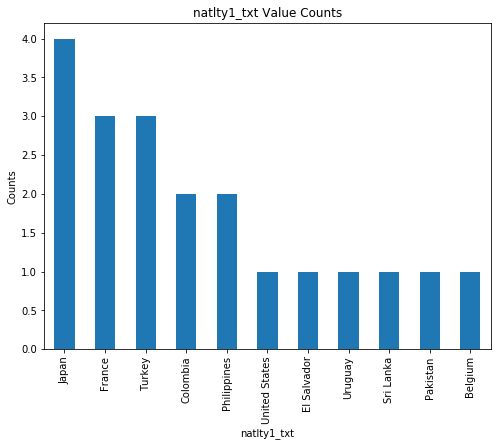

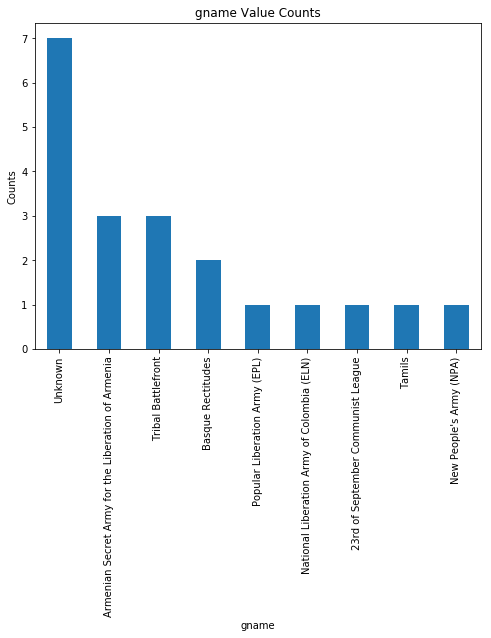

In [12]:
import seaborn as sns

# custom function for boxplot
def plot_bar(df, col):
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().plot.bar()
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Counts'); plt.show()
    
# Plot variables of interest
plot_bar(attacks_unknown_month, 'country_txt'); plot_bar(attacks_unknown_month, 'city');
plot_bar(attacks_unknown_month, 'success'); plot_bar(attacks_unknown_month, 'attacktype1_txt');
plot_bar(attacks_unknown_month, 'weaptype1_txt'); plot_bar(attacks_unknown_month, 'targtype1_txt');
plot_bar(attacks_unknown_month, 'natlty1_txt'); plot_bar(attacks_unknown_month, 'gname') 

Lets take a comparison look at the success rate percentage for attacks for the entire sample population of the dataset and from our small subset for attacks where the year is unknown and see if there is any significant difference.

In [13]:
print(df.success.value_counts())
percent_success_entire_pop = round(df.success.value_counts()[1] / df.success.count(), 2)
percent_success_entire_pop

1    169795
0     21669
Name: success, dtype: int64


0.89

In [14]:
print(attacks_unknown_month.success.value_counts())
percent_success_subset = round(attacks_unknown_month.success.value_counts()[1] / attacks_unknown_month.success.count(), 2)
percent_success_subset

1    19
0     1
Name: success, dtype: int64


0.95

We can see that the success percentage is high as an entire sample population to begin with at 95%, our subset of attacks where the year for attacks is unknown is 89%. 
    
   Lets get back on track to establishing our datetime object and then using this as an index now that we've explored a bit deeper into these attacks where the month was unknown. Even though the number of attacks with month unknown is very low and rather insignificant in the grand scheme of things, it was interesting nonetheless to take a closer look at them. Just because these observations are minimal in volume, we still would rather not delete these rows with missing month values for the sake of building a datetime object, instead lets go ahead and set to a randomly drawn upon value between 1-12 using "random" for all month values that are '0'. this will allow for us to build out the datetime without having to delete any of our observations. Later on null values will need to be dealt with, though, before any machine learning processes. 
   I will also build a indicator variable to flag missing and or "0" value,  if quantity is large enough to build what would be a resonable variable with. We will need to check this for "iday" also before building out datetime object.

In [15]:
df.imonth.value_counts().sort_index()

0        20
1     15839
2     14626
3     16013
4     15994
5     17827
6     16198
7     17165
8     16565
9     14939
10    16455
11    15643
12    14180
Name: imonth, dtype: int64

In [16]:
# replace zeros for month input with a number between 1 and 12
#df.loc[df.imonth == 0, 'imonth'] = df.loc[df.imonth == 0, 'imonth'].apply(lambda x: random.randint(1, 12))
condition = df.imonth == 0
df.loc[condition, 'imonth'] = df.loc[condition, 'imonth'].apply(lambda x: np.random.randint(1, 13))

df.imonth.value_counts().sort_index()

1     15839
2     14627
3     16016
4     15995
5     17828
6     16200
7     17168
8     16568
9     14940
10    16457
11    15645
12    14181
Name: imonth, dtype: int64

We need to do the same thing for "iday" column's values that are "0". We can see below, we've got 891 'iday' inputs that are "0" that need to be filled. Again I will choose to fill these zero values randomly, but this time with a number between 1-30 for months with only 30 days and 1-31 for the remaining months. I will also build an indicator variable for missing iday-values because there are a reasonable number to do so. Whether this variable will be kept around for prediction determined by its predictive power in the model is still tbd

In [17]:
feb_days = df.loc[(df.imonth == 2) & (df.iday == 0), 'iday']
feb_days = feb_days.apply(lambda x: np.random.randint(1, 29))

In [18]:
# alternative = df.iday.loc[np.where(df.imonth.isin([4, 6, 9, 11]) & (df.iday == 0))]
months_30d = df.loc[(df.imonth.isin([4, 6, 9, 11])) & (df.iday == 0), 'iday']
months_30d_fill = months_30d.apply(lambda x: np.random.randint(1, 31))

In [19]:
months_31d = df.loc[(df.imonth.isin([1, 3, 5, 7, 8, 10, 12])) & (df.iday == 0), 'iday']
months_31d_fill = months_31d.apply(lambda x: np.random.randint(1, 32))

In [20]:
updated_iday = months_30d_fill.append(months_31d_fill).append(feb_days)
updated_iday.shape

(891,)

Below I will drop all entries from our original "iday" column where input is "0" then append our "updated_iday" series to the original, confirm there are no remaining "0" values in the newly built "day" column and drop original.

In [21]:
drop_0_days = list(df.iday.loc[df.iday == 0].index)
iday = df.iday.drop(drop_0_days) 
iday_filled = iday.append(updated_iday)
print('Confirm total number of values equal to zero for iday_filled: ' + str(int(iday_filled.loc[iday_filled == 0].count())))

df['day'] = pd.Series(iday_filled, index=df.index)

Confirm total number of values equal to zero for iday_filled: 0


Now, we can finally build out our datetime after removing all zeros ("0") in "imonth" and "iday" columns

In [22]:
df['date'] = df.iyear.astype(str) + '-' + df.imonth.astype(str) + '-' + df.day.astype(str)

# drop day, no longer needed
df.drop(columns='day', inplace=True)

In [23]:
# build datetime obj from "date" 
#dates = pd.to_datetime(df.date.to_list())

# Set datetime object as index. This will make for a more intuitive reference.
#df = df.set_index(dates)

Before we get to actually make use of our datetime index, we still have alot of cleaning to do. Lets continue to move forward with getting the data ready for analysis. The first steps i'll take in the cleaning process will be to **Consolidate and rename columns and deal with missing values and data-types.** Sometimes variables can be pretty confusing to interpret. One way to create better understanding for yourself as well as for others, is to simply rename the variables to something more interpretable. With every set of data, is some form data description for all of the variables of the dataset such as the [GTD Codebook](https://www.start.umd.edu/gtd/downloads/Codebook.pdf). Missing values such as "NaN", or null values will need to be managed as well as make any data-type corrections.

**Next Steps:**

    1. Combine the columns that are the source references scited to compile info on incidents and rename 'scitations'
    2. Rename select columns for added clarity and interpretation
    3. deal missing values
    4. data-type correction

**(1) Consolidate Columns**
- like most processes in data science, this will be iterative in the sense that I may later find additional columns where this will be done. For starters I will begin with combining all of the scitation columns into a single column names "scitations". As more potential consolidation options arise, they will be dealt with at that time.

In [24]:
df['scitations'] = df['scite1'].astype(str) + ' ... ' + df['scite2'] + ' ... ' + df['scite3']
print(df.scitations.dropna().head(2))
print(df.scitations.dropna()[5])

df.drop(columns=['scite1', 'scite2', 'scite3'], inplace=True)

5    "Police Chief Quits," Washington Post, January...
8    Tom Bates, "Rads: The 1970 Bombing of the Army...
Name: scitations, dtype: object
"Police Chief Quits," Washington Post, January 2, 1970. ... "Cairo Police Chief Quits; Decries Local 'Militants'," Afro-American, January 10, 1970. ... Christopher Hewitt, "Political Violence and Terrorism in Modern America: A Chronology," Praeger Security International, 2005.


**(2) Rename Columns**

In [25]:
df.rename(columns={'nhostkid':'n_hostages',
                   'nhostkidus':'n_ushostages',
                   'hostkidoutcome_txt':'hostage_outcome_txt',
                   'corp1':'targ_corpgov1',
                   'corp2':'targ_corpgov2',
                   'corp3':'targ_corpgov3',
                   'target1':'targ_specfc1', 
                   'target2':'targ_specfc2',
                   'target3':'targ_specfc3',
                   'natlty1_txt':'targ_natlty1_txt',
                   'natlty1':'targ_natlty1',
                   'nperps':'nattackers',
                   'nperpcap':'nattackers_captured',
                   'claimed':'responsibility_claimed',
                   'claimmode':'claim_type',
                   'claimmode_txt':'claim_type_txt',
                   'compclaim':'responsibility_claim_multiple',
                   'gname':'terr_grp',
                   'gname2':'terr_grp2',
                   'gname3':'terr_grp3',
                   'gsubname':'terr_grp_subname',
                   'gsubname2':'terr_grp_subname2',
                   'gsubname3':'terr_grp_subname3',
                   'propextent_txt':'property_damage_txt',
                   'INT_ANY':'International_attk',
                   'multiple': 'connctd_attk'},inplace=True)

**(3) Dealing with missing values**

Process:

    
    1. Build subset df of all cols w/ missing vals (only float and object type. Integer-type has no missing)
    2. Correct/replace all string-type inputs in numeric columns referencing null/missing values for entire dataframe
    3. build custom function that calculates % missing of each column and execute it on our subset containing missing vals
    4. select columns w/ greater than or equal to 95% missing values 
    5. (optional, can come back to if necessary) create a indicator variable for EVERY column where it contains missing values
    6. (optional) drop cols w/ >= 95% missing vals

Any missing value labeled "Not Available" vs a NaN value will effect entire column where it lies. String values are object a data-type and will convert entire column to object. I do believe from reading the codebook that our dataset could contain such inputs identical to example ("Not Available") but I am unsure in which locations. If so, they will need to be replaced with null values(below).

In [26]:
#1
df = df.replace({'Not Available':np.nan})

#2
int_cols = df.select_dtypes('int64'); print('Shape of "int_cols":  ' + str(int_cols.shape))
float_cols = df.select_dtypes('float64'); print('Shape of "float_cols":' + str(float_cols.shape))
cat_cols = df.select_dtypes('object').astype('category'); print('Shape for "cat_cols": ' + str(cat_cols.shape))

#compute total sum of missing inputs for each data-type and print result
int_tot = int_cols.isnull().sum().sum()
float_tot = float_cols.isnull().sum().sum()
cat_tot = cat_cols.isnull().sum().sum()
string = "We have a total of {} missing values in our integer columns, {} for floats and {} for objects."
print('\n')
print(string.format(int_tot, float_tot, cat_tot))

Shape of "int_cols":  (191464, 24)
Shape of "float_cols":(191464, 53)
Shape for "cat_cols": (191464, 56)


We have a total of 0 missing values in our integer columns, 7040725 for floats and 7147750 for objects.


In [27]:
#3
def calc_perc_miss(df):
    valid = df.notnull().sum()
    null = df.isnull().sum()
    tot = valid + null
    percent_miss = null / tot
    percentage = percent_miss.sort_values(ascending=False)
    return(percentage)

# establish subset of original df for all columns that have missing values ("floats", and "cats")
cols_w_miss = pd.concat([float_cols, cat_cols], axis=1)
col_list = list(cols_w_miss.columns)
df_col_miss = df[col_list]

# execute custom func on subset
df_miss_percent = calc_perc_miss(df_col_miss)

#4
cols_95_miss = list(df_miss_percent[df_miss_percent >= 0.95].index)
print('There are {} columns that are missing 95% or more values (drop optional).'.format(len(cols_95_miss)) + '\n')
print('List of columns with >= 95% missing values:\n\n' + str(cols_95_miss))

There are 43 columns that are missing 95% or more values (drop optional).

List of columns with >= 95% missing values:

['terr_grp_subname3', 'weapsubtype4', 'weapsubtype4_txt', 'weaptype4_txt', 'weaptype4', 'claimmode3', 'claimmode3_txt', 'terr_grp_subname2', 'divert', 'claim3', 'guncertain3', 'terr_grp3', 'attacktype3_txt', 'attacktype3', 'ransomnote', 'ransompaidus', 'ransomamtus', 'claimmode2_txt', 'claimmode2', 'ransompaid', 'targ_corpgov3', 'targsubtype3', 'targsubtype3_txt', 'natlty3', 'natlty3_txt', 'targ_specfc3', 'targtype3', 'targtype3_txt', 'ransomamt', 'weapsubtype3', 'weapsubtype3_txt', 'weaptype3_txt', 'weaptype3', 'claim2', 'guncertain2', 'terr_grp2', 'kidhijcountry', 'nhours', 'responsibility_claim_multiple', 'terr_grp_subname', 'attacktype2_txt', 'attacktype2', 'ndays']


Dropping columns altogether is one option, but may not be the best choice even for columns that hold an extreme majority of missing values like the ones displayed in list above.

For now, I will keep ALL columns with missing values as it wont affect the process of exploring our data during the next stage. Later on when time to perform machine learning tasks, all missing values will need to be imputed because they'll need to be in numerical form before performing machine learning tasks.

An alternative approach (and there are many) to simply dropping columns with large number of NaN values would be to create a indicator/flag column, for all columns with ANY missing values (because even these missing could be potentially insightful in some way) then impute missing values with mean or median fill strategy, but not until after after doing EDA. The reason for waiting to do so after EDA is one may choose to impute differently, determined by the distribution of present values in selected column. If the distribution is skewed and possible presence of outliers, imputing with median value opposed to mean would be better, but we wont know what the distributions look until the data has been explored. 

At a later time we can still decide to drop these columns that initially had (before imputation) an extremely high percentage of null values if determined they won't be of any predictive use.

Below, I will _(step 5 from the process defined a few cells above)_ create indicator variables to flag where the missing values are, for each column with ANY values missing.

In [ ]:
#5
#for col in df:
    #if df[col].isnull().any() == True:
        #df[col+'_NaNs'] = df[col].isnull() * 1

#indicator_vars = [c for c in df if '_NaNs' in c]

#print('Total number of indicator variables created:' + ' ' + str(len(indicator_vars)) + '\n')
#print('List of every indicator variable for dataframe:\n\n' + str(indicator_vars))

In [ ]:
#6 (optional) drop every column that hase 95% or greater missing values
#df = df.drop(cols_95_miss, 1)

df.shape

**(4) Data-Type Correction**

Lets make sure the variables, are where they are supposed to be, and labeled incorrectly. There may potentially be variables currently categorized under the wrong data-type which will need to be adjusted and if needed, rename them for better clarity.
   - **integer-type**
   - **float-type**
   - **object-type** (categorical and text data)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191464 entries, 0 to 191463
Columns: 134 entries, eventid to scitations
dtypes: datetime64[ns](1), float64(53), int64(24), object(56)
memory usage: 195.7+ MB


Lets take a look at our "object" type data for each kind, categoric columns and columns containing strings of text. First, I will make sure there are no columns of object-type type that contain numerical values. If any, these will need to be converted to numeric-type.

In [29]:
cat_cols.head()

,approxdate,country_txt,region_txt,provstate,city,location,summary,alternative_txt,attacktype1_txt,attacktype2_txt,attacktype3_txt,targtype1_txt,targsubtype1_txt,targ_corpgov1,targ_specfc1,targ_natlty1_txt,targtype2_txt,targsubtype2_txt,targ_corpgov2,targ_specfc2,natlty2_txt,targtype3_txt,targsubtype3_txt,targ_corpgov3,targ_specfc3,natlty3_txt,terr_grp,terr_grp_subname,terr_grp2,terr_grp_subname2,terr_grp3,terr_grp_subname3,motive,claim_type_txt,claimmode2_txt,claimmode3_txt,weaptype1_txt,weapsubtype1_txt,weaptype2_txt,weapsubtype2_txt,weaptype3_txt,weapsubtype3_txt,weaptype4_txt,weapsubtype4_txt,weapdetail,property_damage_txt,propcomment,divert,kidhijcountry,ransomnote,hostage_outcome_txt,addnotes,dbsource,related,date,scitations
0,NaN,Dominican Republic,Central America & Caribbean,National,Santo Domingo,NaN,NaN,NaN,Assassination,NaN,NaN,Private Citizens & Property,Named Civilian,NaN,Julio Guzman,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN,1970-7-2,NaN
1,NaN,Mexico,North America,Federal,Mexico city,NaN,NaN,NaN,Hostage Taking (Kidnapping),NaN,NaN,Government (Diplomatic),"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mexico,NaN,NaN,NaN,PGIS,NaN,1970-8-24,NaN
2,NaN,Philippines,Southeast Asia,Tarlac,Unknown,NaN,NaN,NaN,Assassination,NaN,NaN,Journalists & Media,Radio Journalist/Staff/Facility,Voice of America,Employee,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN,1970-1-6,NaN
3,NaN,Greece,Western Europe,Attica,Athens,NaN,NaN,NaN,Bombing/Explosion,NaN,NaN,Government (Diplomatic),Embassy/Consulate,NaN,U.S. Embassy,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosives,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN,1970-1-24,NaN
4,NaN,Japan,East Asia,Fukouka,Fukouka,NaN,NaN,NaN,Facility/Infrastructure Attack,NaN,NaN,Government (Diplomatic),Embassy/Consulate,NaN,U.S. Consulate,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incendiary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incendiary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,NaN,1970-1-28,NaN


It doesnt look like there are any object-type data containing numerical values that need to be converted.

In [30]:
df.shape

(191464, 134)

In [31]:
df.to_csv(r"C:\Users\Emtma_000\!Desktop\Data Science\Data Sets projects\Capstone Project (1)\dfclean.csv", header=True)